¡Hola!

Mi nombre es Tonatiuh Cruz. Me complace revisar tu proyecto hoy.

Al identificar cualquier error inicialmente, simplemente los destacaré. Te animo a localizar y abordar los problemas de forma independiente como parte de tu preparación para un rol como data-scientist. En un entorno profesional, tu líder de equipo seguiría un enfoque similar. Si encuentras la tarea desafiante, proporcionaré una pista más específica en la próxima iteración.

Encontrarás mis comentarios a continuación - **por favor no los muevas, modifiques o elimines**.

Puedes encontrar mis comentarios en cajas verdes, amarillas o rojas como esta:

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Éxito. Todo está hecho correctamente.
</div>

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Observaciones. Algunas recomendaciones.
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Necesita corrección. El bloque requiere algunas correcciones. El trabajo no puede ser aceptado con comentarios en rojo.
</div>

Puedes responderme utilizando esto:

<div class="alert alert-block alert-info">
<b>Respuesta del estudiante.</b> <a class="tocSkip"></a>
</div>

# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

1. Descarga los datos y haz el remuestreo por una hora.

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import time
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
#Cargar los datos y se eliminan espacios en los nombres de columnas
data = pd.read_csv('/datasets/taxi.csv')

#Asegurar que no hay espacios en los nombres de las columnas
data.columns = data.columns.str.strip()  

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
#Se convierte la columna tipo 'datetime' a tipo datetime y se establece como índice
data['datetime'] = pd.to_datetime(data['datetime'])

#Establecer 'datetime' como índice del DataFrame
data.set_index('datetime', inplace=True)


In [5]:
#Remuestreo por una hora
data_hourly = data.resample('H').sum()

#Se observan los datos transformados por hora
data_hourly.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Buen trabajo transformado la columna datetime para agrupar el número de órdenes por hora. 
</div>

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


<AxesSubplot:>

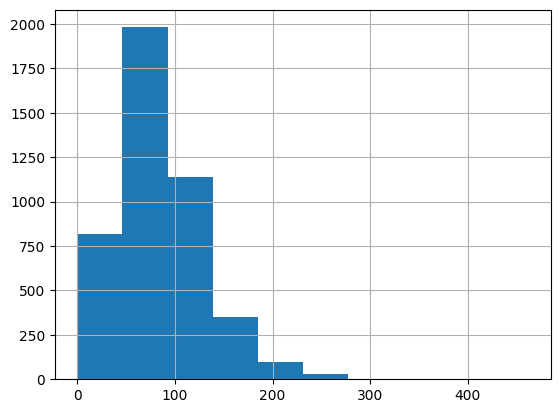

In [6]:
#Descripción de los datos
print(data_hourly.describe())

#Gráfico de la distribución
data_hourly['num_orders'].hist()

## Preparación

In [7]:
def make_features(data, rolling_mean_size=10):
    df = data.copy()
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek_num'] = df.index.dayofweek
    df['hour'] = df.index.hour
        
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

data_with_features = make_features(data_hourly)

In [8]:
#Separación de características y etiquetas
X = data_with_features.drop('num_orders', axis=1)
y = data_with_features['num_orders']


In [9]:
#División inicial en entrenamiento y prueba (10% para prueba)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1, random_state=42)

#División de entrenamiento y validación (10% para validación de los datos restantes)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

# Verificar los tamaños de los conjuntos
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de validación: {X_test.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_val.shape[0]}")

Tamaño del conjunto de entrenamiento: 3974
Tamaño del conjunto de validación: 397
Tamaño del conjunto de prueba: 45


In [10]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
X_val = X_val.fillna(0)



<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Muy bien, ya cuentas con las tablas necesarias para el entrenamiento y prueba de los modelos. Mi única recomendación es que además crearas un conjunto de validación, el cual luego puedes usar para el ajuste de hiperparámetros. Después de asignar el 10% al conjunto de prueba, puedes asignar un 10% a los datos restantes al conjunto de validación y el resto al de entrenamiento.
</div>

## Análisis

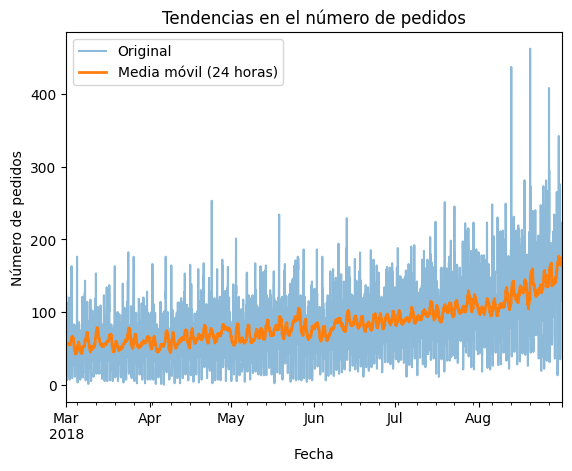

            num_orders
num_orders         1.0


In [11]:
# Análisis de tendencias con media móvil
data_hourly['num_orders'].plot(label='Original', alpha=0.5)
data_hourly['num_orders'].rolling(window=24).mean().plot(label='Media móvil (24 horas)', linewidth=2)

# Configurar la gráfica
plt.title('Tendencias en el número de pedidos')
plt.xlabel('Fecha')
plt.ylabel('Número de pedidos')
plt.legend()
plt.show()

# Correlación
correlation = data_hourly.corr()
print(correlation)

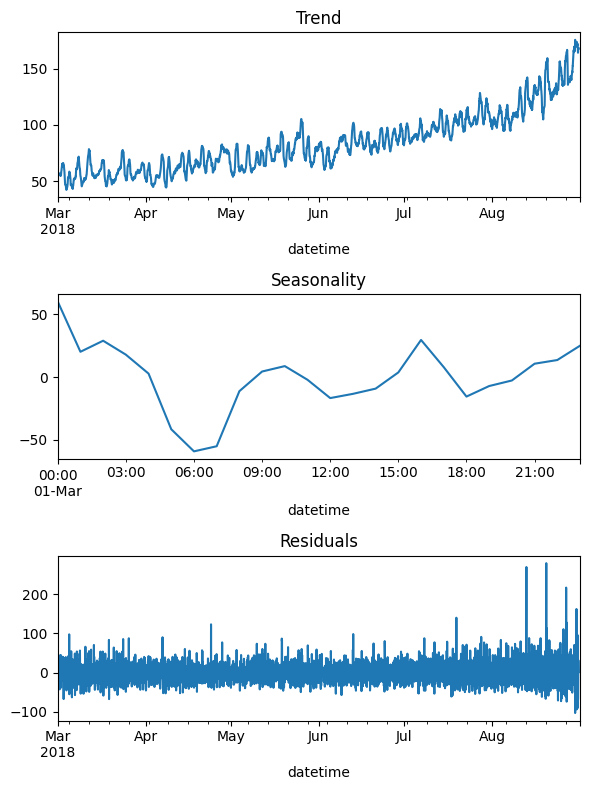

In [12]:
data = data.resample('1H').sum()
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['1 March 2018'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Muy buena visualización. Gracias a la media móvil, puedes identificar de mejor forma la tendencia, ya que esta maneja de manera más efectiva el ruido en el conjunto de datos.
</div>

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Excelentes gráficas. Al eliminar el ruido es posible observar claramente la tendencia de los datos y la estacionalidad también está bastante marcada. Mi única sugerencia para observar la estacionalidad diaria podrías usar la siguiente visualización:
    
    decomposed.seasonal['1 March 2018'].plot(ax=plt.gca())
    plt.title('Seasonality')
    
Si bien el día 1 de marzo de 2018 es solo un ejemplo, puede servir para darse una idea general de los patrones repetitivos de los pedidos de taxi durante un día.
</div>

## Formación

In [13]:
X_train

,month,day,dayofweek_num,hour,rolling_mean
datetime,,,,,
2018-08-16 00:00:00,8,16,3,0,140.0
2018-07-31 23:00:00,7,31,1,23,92.4
2018-04-06 13:00:00,4,6,4,13,49.5
2018-04-21 07:00:00,4,21,5,7,97.4
2018-05-16 05:00:00,5,16,2,5,83.0
...,...,...,...,...,...
2018-07-22 12:00:00,7,22,6,12,78.1
2018-03-20 10:00:00,3,20,1,10,42.3
2018-07-07 20:00:00,7,7,5,20,82.1


In [14]:
y_train

datetime
2018-08-16 00:00:00    202
2018-07-31 23:00:00    125
2018-04-06 13:00:00     44
2018-04-21 07:00:00     24
2018-05-16 05:00:00     14
                      ... 
2018-07-22 12:00:00    148
2018-03-20 10:00:00     58
2018-07-07 20:00:00     76
2018-08-05 04:00:00    122
2018-04-05 20:00:00     61
Name: num_orders, Length: 3974, dtype: int64

In [15]:
#RandomForest
model = RandomForestRegressor()
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [16]:
X_train.values

array([[  8. ,  16. ,   3. ,   0. , 140. ],
       [  7. ,  31. ,   1. ,  23. ,  92.4],
       [  4. ,   6. ,   4. ,  13. ,  49.5],
       ...,
       [  7. ,   7. ,   5. ,  20. ,  82.1],
       [  8. ,   5. ,   6. ,   4. , 106. ],
       [  4. ,   5. ,   3. ,  20. ,  52.9]])

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Para solucionar el error te recomiendo verifica que en la svariables de X_train o y_train no están definidas correctamente o están vacías
</div>


## Prueba

In [17]:

#Predicción en el conjunto de prueba
y_pred = grid_search.best_estimator_.predict(X_test)

#Cálculo del RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

RMSE: 22.586857704144908


<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Para solucionar el error te recomiendo verifica que en la svariables de X_train o y_train no están definidas correctamente o están vacías
</div>

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48

<div class="alert alert-block alert-warning">
<b>Resumen de la revisión 1</b> <a class="tocSkip"></a>

Es muy buen trabajo, Jorge. Solo te dejé unas recomendaciones de la asignación de los datos a un conjunto de validación además del de prueba y entrenamiento y por último, una sugerencia para entender y ajustar el error de el random forest. Quedo pendiente de tus dudas y comentarios.
</div>